# Pandas profiling

Felix van der Spek  
2021-11-01

This notebook was contributed by [Felix van der Spek](), JADS Data
Science Foundation for Experts class, November 2021

For those seeking to improve their exploratory data analysis workflow,
the [pandas
profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/)
is a good library to use. We demonstrate it here using the Ames housing
case. Also, the metadata from the original journal paper is used to
generate a properly documented report.

Since the reports can get quite large, it is recommended to save it in a
separate file.

In [1]:
import json
import re
from fuzzywuzzy import fuzz
import pandas as pd
import requests
from pandas_profiling import ProfileReport


DATASET_URL = "https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true"
DATASET_METADATA_URL = "http://jse.amstat.org/v19n3/decock/DataDocumentation.txt"
VARIABLE_DEFINITION_FILENAME = "dataset_variable_definition.json"

/Users/dkapitan/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')

In [2]:
def fetch_variable_definitions(
    dataset_url=DATASET_URL, 
    dataset_metadata_url=DATASET_METADATA_URL, 
    filename=VARIABLE_DEFINITION_FILENAME
):
    """Fetch variable definitions from dataset metadata."""

    response = requests.get(dataset_metadata_url)

    pattern = re.compile(r'(?P<variable>.*?)(?:\s*\(.*\)\s*:\s*)(?P<description>.*)')
    matches = re.finditer(pattern, response.text)
    
    definitions = {
        match.group('variable'): match.group('description') 
        for match in matches 
        if match is not None
    }
    definitions = {k.strip(): v.strip() for k, v in definitions.items()}

    print(f"number of variables in metadata: {len(definitions)}")

    # get dataset so we can map variable names from dataset to metadata
    df = pd.read_csv(dataset_url)
    print(f"number of variables in dataset: {len(df.columns)}")

    # quick sanity check
    assert len(definitions) == len(df.columns), "number of columns don't match"

    column_names = pd.Series(df.columns)
    for variable in definitions.copy():
        # use Levenshtein distance to fuzzy match variable names from dataset to metadata
        levenshtein_scores = column_names.apply(fuzz.ratio, args=(variable,))
        column_name = column_names[levenshtein_scores == levenshtein_scores.max()].iat[0]
        
        # using the fuzz.ratio method, we incorrectly missname one variable
        # which we have to correct manually
        if variable == "Kitchen":
            column_name = "Kitchen AbvGr"
            
        # user feedback
        if variable != column_name:
            print(f"altering: {variable} -> {column_name}")

        definitions[column_name] = definitions.pop(variable)

    with open(filename, "w") as output_file:
        json.dump(obj=definitions, fp=output_file, indent=4)
        print(f"saved variable names and descriptions to {filename}")

In [3]:
fetch_variable_definitions()

number of variables in metadata: 82
number of variables in dataset: 82
altering: Exterior 1 -> Exterior 1st
altering: Exterior 2 -> Exterior 2nd
altering: BsmtFinType 2 -> BsmtFin Type 2
altering: HeatingQC -> Heating QC
altering: Bedroom -> Bedroom AbvGr
altering: Kitchen -> Kitchen AbvGr
altering: KitchenQual -> Kitchen Qual
altering: TotRmsAbvGrd -> TotRms AbvGrd
altering: FireplaceQu -> Fireplace Qu
altering: 3-Ssn Porch -> 3Ssn Porch
saved variable names and descriptions to dataset_variable_definition.json

Creating a profile report interactively in you notebook using
`df.profile_report()` or `profile.to_notebook_iframe()` may cause issues
since the cell output can quickly get to large. Instead, we generate a
separate file with annotated variables.

In [4]:
with open(VARIABLE_DEFINITION_FILENAME) as f:
    variables = json.load(f)

/Users/dkapitan/.local/lib/python3.10/site-packages/pandas_profiling/model/correlations.py:55: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  warnings.warn(
/Users/dkapitan/.local/lib/python3.10/site-packages/missingno/missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/Users/dkapitan/.local/lib/python3.10/site-packages/pandas_profiling/model/missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is probl

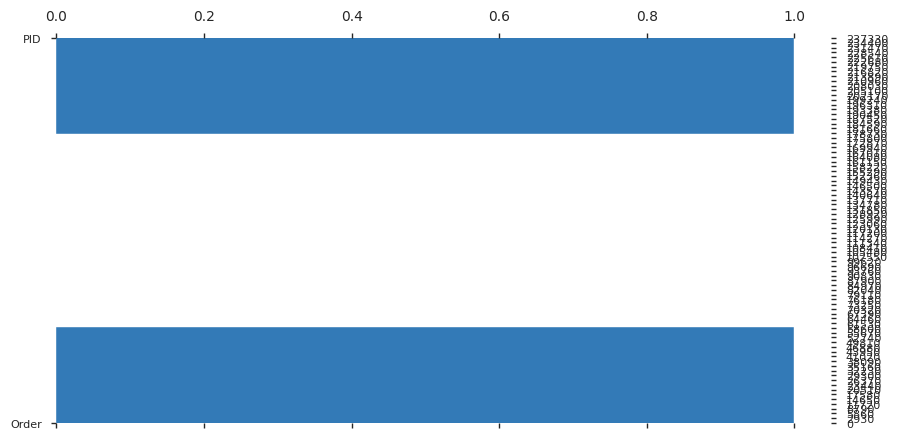

In [5]:
df = pd.read_csv(DATASET_URL)
profile = ProfileReport(
    df,
    explorative=True,
    title="Ames Housing Data Set Profile",
    dataset={
        "description": "Profiling report for the Ames housing dataset.",
        "creator": "Felix van der Spek",
        "url": DATASET_URL,
    },
    variables=variables,
)
profile.to_file("ames.html")

Download and open the file in Google Chrome or Firefox. Wait for the
file to load completely, after which navigation will work.